### Create MapBox tiles (mbtiles) 
Based on [this Sci-team notebook](https://github.com/Vizzuality/sci_team_data_bank/blob/master/Projects/usa-resilience-opportunity-map/processing/create_MBTiles.ipynb)

If not installed, install tippecanoe in terminal with: $brew install tippecanoe

## python libraries

In [6]:
import pandas as pd 
import geopandas as gpd
import getpass
import requests
import shapely.wkb 
import subprocess
import os
import zipfile
import glob
import matplotlib.pyplot as plt

## Utils

In [3]:
def create_mbtiles(source_path, dest_path, layer_name, opts="-zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel"):
    """
    Use tippecanoe to create a MBTILE at dest_path from source_path.
    layer_name is used for the name of the layer in the MBTILE.
    Regex file path (/*.geojson) is supported for source_path.
    """
    cmd = f"tippecanoe -o {dest_path} -l {layer_name} {opts} {source_path}"
    print(f"Processing: {cmd}")
    r = subprocess.call(cmd, shell=True)
    if r == 0:
        print("Task created")
    else:
        print("Task failed")
    print("Finished processing")

## Read data
The data includes the tourism regions and other polygon and point contextual data (airports, ski resorts, tourism centers, etc)
* All layers must be sjoined with the tourism-regions layer to make sure we can filter on the map  
* The names of the tourism regions are modified to match the syntax used in the API

In [7]:
path = '../data/raw/'
ziplist = glob.glob(f'{path}/*.zip')
ziplist

['../data/raw/BCGW_7113060B_1627367952871_1544.zip',
 '../data/raw/BCGW_7113060B_1628167339306_10764.zip',
 '../data/raw/BC_HelloBC_Accommodations_Listings.zip',
 '../data/raw/BCGW_7113060B_1627367115435_3236.zip',
 '../data/raw/BCGW_7113060B_1627368738210_2232.zip']

### Tourism regions

In [2]:
region = gpd.read_file('../data/raw/ADM_TOURISM_REGIONS_SP.geojson')
#region

In [3]:
rename = {'Vancouver Island':'vancouver_island',
         'Vancouver, Coast and Mountains':'vancouver_coast_and_mountains',
         'Thompson Okanagan':'thompson_okanagan',
         'Kootenay Rockies':'kootenay_rockies',
         'Cariboo Chilcotin Coast':'cariboo_chilcotin_coast',
         'Northern British Columbia':'northern_british_columbia'}
region.replace({'TOURISM_REGION_NAME':rename}, inplace =True)

#Save first time
#region.to_file('../data/raw/ADM_TOURISM_REGIONS_SP_apiname.geojson', driver="GeoJSON")

In [12]:
from pyproj.crs import CRS
## Albers Equal Area projection ('EPSG:9822' does not work, I import form Pyproj)
aea = CRS('+proj=aea +lat_1=29.5 +lat_2=42.5')

In [15]:
region.to_crs(aea).geometry.area*1e-6 ## same values as already in file

0     78991.409798
1     39890.313324
2     80575.398474
3     76121.808480
4    135077.988557
5    619128.054886
dtype: float64

In [16]:
region['AREAkm2'] = round(region['FEATURE_AREA_SQM']/1e6,2)
region[['TOURISM_REGION_NAME','AREAkm2']]

,TOURISM_REGION_NAME,AREAkm2
0,vancouver_island,78991.37
1,vancouver_coast_and_mountains,39890.27
2,thompson_okanagan,80575.39
3,kootenay_rockies,76121.80
4,cariboo_chilcotin_coast,135077.95
5,northern_british_columbia,619127.72


### Contextual layers
For all layers: 
1. Join with tourism layer to be able to filter by tourism region on the platform map
2. Create mbtiles
3. Upload to TOTA Mapbox

+ Ski resorts
+ First Nations community locations
+ First Nations business list
+ Trails
+ Airports
+ [Wildlife habitats](#Wildlife-Layer) --> Needs extra processing step to split polygons
+ [Economic regions vs Tourism Regions](#Economic-regions)
+ [Campgrounds](#Campgrounds)
+ [Stops of Interest](#Stops-of-Interest)
+ [Tourism Centers](#Tourism-Centers)

In [10]:
# layers = {'ski_resorts': '../data/raw/GSR_SKI_RESORTS_SV.geojson',
#          'first_nations_communities':'../data/raw/FN_COMMUNITY_LOCATIONS_SP.geojson',
#          'first_nations_business':'../data/raw/GSR_INDIGENOUS_BUSINESSES_SV.geojson',
#          'wildlife_habitats':'../data/raw/WCP_WILDLIFE_HABITAT_AREA_POLY.geojson'}
# layers = {'airports': '../data/raw/BCGW_7113060B_1627367952871_1544/GSR_AIRPORTS_SVW.geojson',
#          'trails':'../data/raw/BCGW_7113060B_1627368738210_2232/FTEN_RECREATION_LINES_SVW.geojson'}
layers = {'accommodations': '../data/raw/BC_HelloBC_Accommodations_Listings/GSR_HELLOBC_ACCOMMODATIONS_SVW.geojson'}


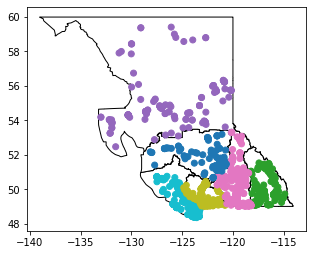

In [11]:
region = gpd.read_file('../data/raw/ADM_TOURISM_REGIONS_SP_apiname.geojson')
for layer in layers.keys():
    gdf = gpd.read_file(layers[layer])
    if layer == 'airports':
        gdf = gdf[gdf['DESCRIPTION'] =='airport'] ### get only airports (exclude heliports and other airways)
    gdf_region = gpd.sjoin(gdf, region[['TOURISM_REGION_NAME','geometry']], how ='inner')
    gdf_region.to_file(f"../data/processed/{layers[layer].split('/')[4].split('.')[0]}"+"_region.geojson", driver="GeoJSON")
    
    fig, ax = plt.subplots(figsize =(5,5))
    region.plot(ax=ax, color='white', edgecolor='black')
    gdf_region.plot(ax=ax, column='TOURISM_REGION_NAME')

    plt.show()
    

In [56]:
gdf = gpd.read_file(layers['airports'])

### Wildlife Layer

In [30]:
## Wildlife layer needs extra step of dividing polygons first before spatial join
region = gpd.read_file('../data/raw/ADM_TOURISM_REGIONS_SP_apiname.geojson')
wildlife_raw= gpd.read_file('../data/raw/WCP_WILDLIFE_HABITAT_AREA_POLY.geojson')

In [ ]:
### Separate multipolygons into individual polygons to be able to cut by country
def divide_multipolygons(gdf):
    df = pd.DataFrame()
    for line in range(len(gdf)):
        if type(gdf.iloc[line]['geometry']) == shapely.geometry.polygon.Polygon:
            merge = gdf.iloc[[line],:]
            df = df.append(merge)  
        else:
            shapes = list(gdf.iloc[line]['geometry'])
            other_data = gdf.iloc[[line],gdf.columns != 'geometry']

            for i in range(len(shapes)):
                merge = pd.DataFrame(data=other_data)
                merge['geometry'] = shapes[i]
                df = df.append(merge)
    return df

In [44]:
#wildlife_split = divide_multipolygons(wildlife_raw)
#wsplit_region = gpd.sjoin(wildlife_split, region[['TOURISM_REGION_NAME','geometry']], how ='inner')
wsplit_region.to_file('../data/processed/WCP_WILDLIFE_HABITAT_AREA_POLY_region.geojson', driver="GeoJSON")

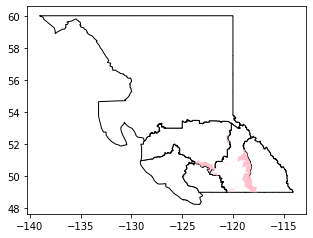

In [40]:
fig, ax = plt.subplots(figsize =(5,5))
region.plot(ax=ax, color='white', edgecolor='black')
wsplit_region[wsplit_region['TOURISM_REGION_NAME']=='thompson_okanagan'].plot(ax=ax, color='pink')
plt.show()

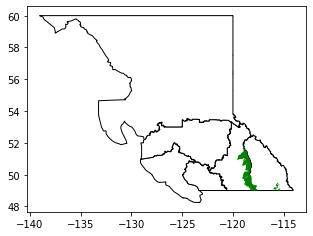

In [41]:
fig, ax = plt.subplots(figsize =(5,5))
region.plot(ax=ax, color='white', edgecolor='black')
wsplit_region[wsplit_region['TOURISM_REGION_NAME']=='kootenay_rockies'].plot(ax=ax, color='green')
plt.show()

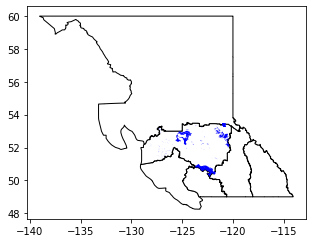

In [43]:
fig, ax = plt.subplots(figsize =(5,5))
region.plot(ax=ax, color='white', edgecolor='black')
wsplit_region[wsplit_region['TOURISM_REGION_NAME']=='cariboo_chilcotin_coast'].plot(ax=ax, color='blue')
plt.show()

In [39]:
wsplit_region = gpd.sjoin(wildlife_spli, region[['TOURISM_REGION_NAME','geometry']], how ='inner')

### Economic regions

In [4]:
region = gpd.read_file('../data/raw/ADM_TOURISM_REGIONS_SP_apiname.geojson')
dev= gpd.read_file('../data/raw/BCGW_7113060B_1628167339306_10764/CEN_ECONOMIC_REGIONS_SVW.geojson')

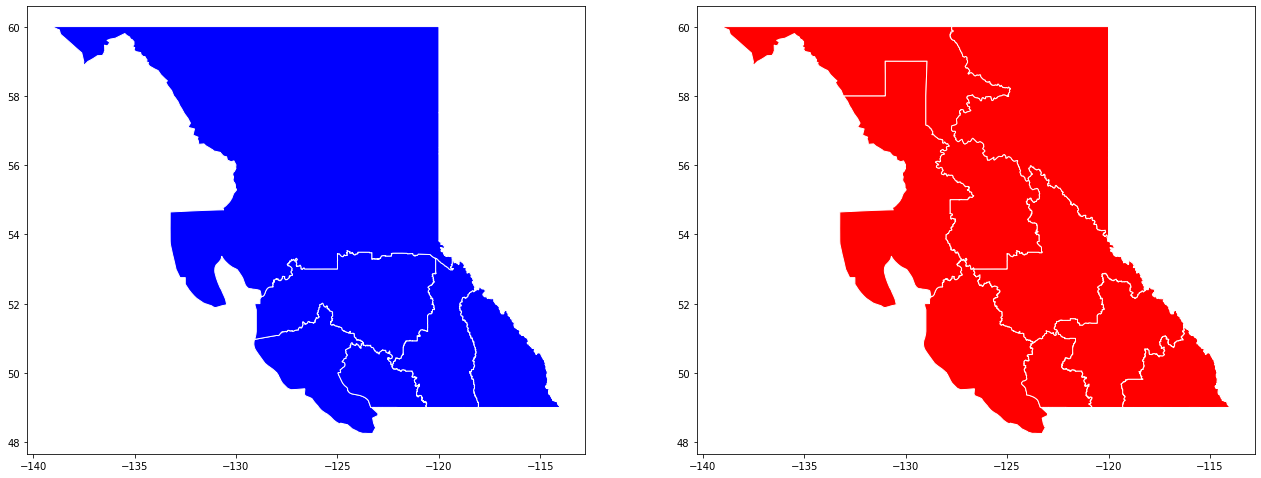

In [11]:
fig, axs = plt.subplots(nrows=1,ncols = 2,figsize =(22,10))
region.plot(ax=axs[0], color='blue', edgecolor='white')
dev.plot(ax=axs[1],color='red', edgecolor='white')

plt.show()
fig.savefig('../data/tourism_vs_economic_regions.png',dpi=100,bbox='tight')

In [45]:
region.TOURISM_REGION_NAME.unique()

array(['vancouver_island', 'vancouver_coast_and_mountains',
       'thompson_okanagan', 'kootenay_rockies', 'cariboo_chilcotin_coast',
       'northern_british_columbia'], dtype=object)

In [46]:
dev.ECONOMIC_REGION_NAME.unique()

array(['Vancouver Island and Coast / Île de Vancouver et la côte',
       'Lower Mainland--Southwest / Lower Mainland--Sud-ouest',
       'Thompson--Okanagan', 'Kootenay', 'Cariboo',
       'North Coast / Côte-nord', 'Nechako', 'Northeast / Nord-est'],
      dtype=object)

In [47]:
correspondence = {'Vancouver Island and Coast / Île de Vancouver et la côte':'vancouver_island',
                 'Lower Mainland--Southwest / Lower Mainland--Sud-ouest':'vancouver_coast_and_mountains',
                 'Thompson--Okanagan':'thompson_okanagan',
                 'Kootenay':'kootenay_rockies',
                 'Cariboo':'cariboo_chilcotin_coast',
                 'North Coast / Côte-nord':'northern_british_columbia',
                 'Nechako':'northern_british_columbia',
                 'Northeast / Nord-est':'northern_british_columbia'}

In [48]:
dev['TOURISM_REGION_NAME']= dev['ECONOMIC_REGION_NAME'].map(correspondence)

In [51]:
dev.to_file(f"../data/processed/CEN_ECONOMIC_REGIONS_SVW_region.geojson", driver="GeoJSON")

## Campgrounds

In [31]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

In [39]:
gdf.head()

,Name,Address,City,Postal Code,Sites,Units,Show_on_map,latitude,longitude,geometry
0,Acacia Grove RV Park & Cabins,3814 Riverview Ave E,Spences Bridge,V0K 2L0,33,8.0,True,50.424466,-121.334681,POINT (-121.33468 50.42447)
1,Alpine Meadows Resort,3400 Dunn Lake Road,Clearwater,V0E 1N0,17,48.0,True,51.511437,-120.129750,POINT (-120.12975 51.51144)
2,Alpine Village Resort,718 Swanson Pt. Road,Swansen Point,V0E 2K2,21,7.0,True,50.767246,-119.014512,POINT (-119.01451 50.76725)
3,Anglemont Inn,7387 Estate Drive,Anglemont,V0E 1A0,10,16.0,True,50.970550,-119.200609,POINT (-119.20061 50.97055)
4,Apex Lodge by SkyRun Vacation Rentals,360 Strayhorse Road,Penticton,NaN,NaN,NaN,False,49.390954,-119.903868,POINT (-119.90387 49.39095)


In [7]:
layers = {'campgrounds':'../data/raw/Campgrounds.csv'}

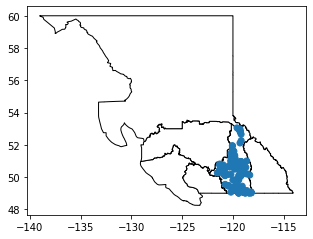

In [40]:
import matplotlib.pyplot as plt

region = gpd.read_file('../data/raw/ADM_TOURISM_REGIONS_SP_apiname.geojson')
for layer in layers.keys():
    df = pd.read_csv(layers[layer])
    gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude)).set_crs("EPSG:4326")
    gdf_region = gpd.sjoin(gdf, region[['TOURISM_REGION_NAME','geometry']], how ='inner')
    ## keep only thompson okanagan campgrounds
    gdf_region = gdf_region[(gdf_region['TOURISM_REGION_NAME'] == 'thompson_okanagan') & (gdf_region['Show_on_map']==True)]
    ## export
    gdf_region.to_file(f"../data/processed/{layers[layer].split('/')[3].split('.')[0]}"+"_region.geojson", driver="GeoJSON")
    
    fig, ax = plt.subplots(figsize =(5,5))
    region.plot(ax=ax, color='white', edgecolor='black')
    gdf_region.plot(ax=ax, column='TOURISM_REGION_NAME')

    plt.show()

## Stops of Interest

In [69]:
layers = {'stopsofinterest':'../data/raw/stopofinterestdata-nov-15-2019.csv'}

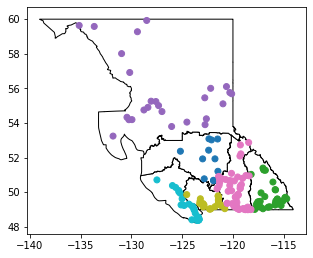

In [70]:
import matplotlib.pyplot as plt

region = gpd.read_file('../data/raw/ADM_TOURISM_REGIONS_SP_apiname.geojson')
for layer in layers.keys():
    df = pd.read_csv(layers[layer],encoding ='latin-1')
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude,df.Latitude)).set_crs("EPSG:4326")
    gdf_clip =gpd.clip(gdf,region)
    gdf_region = gpd.sjoin(gdf_clip, region[['TOURISM_REGION_NAME','geometry']], how ='inner')
    
    ## export
    gdf_region.to_file(f"../data/processed/{layers[layer].split('/')[3].split('.')[0]}"+"_region.geojson", driver="GeoJSON")
    
    fig, ax = plt.subplots(figsize =(5,5))
    region.plot(ax=ax, color='white', edgecolor='black')
    gdf_region.plot(ax=ax, column='TOURISM_REGION_NAME')

    plt.show()

## Tourism Centers

In [71]:
df = pd.read_csv('../data/raw/Visitor Centres_Thompson Okanagan - Final List (DBC).csv',encoding = 'latin-1')

In [72]:
df.columns

Index(['Name (use this one)', 'Alternate Name', 'Tourism Region',
       'Tourism Sub-Region', 'Business Type', 'Address', 'Postal Code',
       'Latitude ', 'Longitude', 'Comments', 'Show_on_map'],
      dtype='object')

In [73]:
df.rename(columns = {'Name (use this one)':'Name', 'Latitude ':'Latitude'}, inplace = True)
df=df[df['Show_on_map']==True]

In [74]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude,df.Latitude)).set_crs("EPSG:4326")

In [75]:
gdf.isnull().any()

Name                  False
Alternate Name         True
Tourism Region        False
Tourism Sub-Region    False
Business Type         False
Address               False
Postal Code           False
Latitude              False
Longitude             False
Comments               True
Show_on_map           False
geometry              False
dtype: bool

In [76]:
layers = {'visitor_centers':'../data/raw/Visitor Centres_Thompson Okanagan - Final List (DBC).csv'}

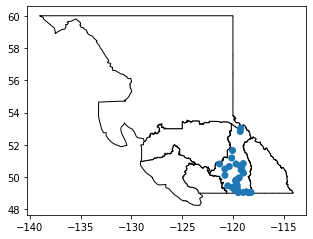

In [77]:
region = gpd.read_file('../data/raw/ADM_TOURISM_REGIONS_SP_apiname.geojson')
for layer in layers.keys():
    gdf_region = gpd.sjoin(gdf, region[['TOURISM_REGION_NAME','geometry']], how ='inner')
    
    ## export
    gdf_region.to_file(f"../data/processed/{layers[layer].split('/')[3].split('.')[0]}"+"_region.geojson", driver="GeoJSON")
    
    fig, ax = plt.subplots(figsize =(5,5))
    region.plot(ax=ax, color='white', edgecolor='black')
    gdf_region.plot(ax=ax, column='TOURISM_REGION_NAME')

    plt.show()

# Create mbtiles

In [15]:
layer_name = "tourism_regions"
source_path = "../data/raw/ADM_TOURISM_REGIONS_SP_apiname.geojson"
dest_path = "../data/tourism_regions.mbtiles"
create_mbtiles(source_path, dest_path, layer_name, opts="-zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel")

Processing: tippecanoe -o ../data/tourism_regions.mbtiles -l tourism_regions -zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel ../data/ADM_TOURISM_REGIONS_SP_newname.geojson
Task created
Finished processing


In [16]:
layer_name = "ski_resorts"
source_path = "../data/processed/GSR_SKI_RESORTS_SV_region.geojson"
dest_path = "../data/processed/ski_resorts.mbtiles"
create_mbtiles(source_path, dest_path, layer_name, opts="-zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel")

Processing: tippecanoe -o ../data/ski_resorts.mbtiles -l ski_resorts -zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel ../data/GSR_SKI_RESORTS_SV_region.geojson
Task created
Finished processing


In [48]:
### First round
mbtiles= {'ski_resorts': {'source':'../data/processed/GSR_SKI_RESORTS_SV_region.geojson', 
                                   'dest':'../data/processed/ski_resorts.mbtiles'},
         'first_nations_communities':{'source':'../data/processed/FN_COMMUNITY_LOCATIONS_SP_region.geojson',
                                      'dest':'../data/processed/first_nations_communities.mbtiles'},
         'first_nations_business':{'source':'../data/processed/GSR_INDIGENOUS_BUSINESSES_SV_region.geojson',
                                   'dest':'../data/processed/first_nations_business.mbtiles'},
         'wildlife_habitats':{'source':'../data/processed/WCP_WILDLIFE_HABITAT_AREA_POLY_region.geojson',
                             'dest':'../data/processed/wildlife_habitats.mbtiles'}}

In [63]:
# Second round
mbtiles= {'airports': {'source':'../data/processed/GSR_AIRPORTS_SVW_region.geojson', 
                                   'dest':'../data/processed/airports.mbtiles'},
         'dev_region':{'source':'../data/processed/CEN_ECONOMIC_REGIONS_SVW_region.geojson',
                                      'dest':'../data/processed/economic_development_regions.mbtiles'},
         'trails':{'source':'../data/processed/FTEN_RECREATION_LINES_SVW_region.geojson',
                                   'dest':'../data/processed/trails.mbtiles'}}

In [43]:
# Third round
mbtiles= {'campgrounds': {'source':'../data/processed/Campgrounds_region.geojson', 
                                   'dest':'../data/processed/campgrounds.mbtiles'}}

In [82]:
# Fourth round
mbtiles= {'stops': {'source':'../data/processed/stopofinterestdata-nov-15-2019_region.geojson', 
                                   'dest':'../data/processed/stops.mbtiles'},
         'visitor_centres':{'source':'../data/processed/Visitor_Centres_Thompson_Okanagan_region.geojson', 
                                   'dest':'../data/processed/visitor_centres.mbtiles'},
         'accommodations':{'source':'../data/processed/GSR_HELLOBC_ACCOMMODATIONS_SVW_region.geojson', 
                                   'dest':'../data/processed/hellobc_accommodations.mbtiles'}}

In [83]:
for layer in mbtiles.keys():
    layer_name = layer
    source_path = mbtiles[layer]['source']
    dest_path = mbtiles[layer]['dest']
    create_mbtiles(source_path, dest_path, layer_name, opts="-zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel")
    

Processing: tippecanoe -o ../data/processed/stops.mbtiles -l stops -zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel ../data/processed/stopofinterestdata-nov-15-2019_region.geojson
Task created
Finished processing
Processing: tippecanoe -o ../data/processed/visitor_centres.mbtiles -l visitor_centres -zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel ../data/processed/Visitor_Centres_Thompson_Okanagan_region.geojson
Task created
Finished processing
Processing: tippecanoe -o ../data/processed/hellobc_accommodations.mbtiles -l accommodations -zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel ../data/processed/GSR_HELLOBC_ACCOMMODATIONS_SVW_region.geojson
Task created
Finished processing


### Upload thorugh [Mapbox Studio]( https://studio.mapbox.com/tilesets/) or Mapbox API


In [2]:
!pwd

/Users/tamarahuete/Documents/Github_repos/tota/data/notebooks


In [3]:
gdf = gpd.read_file('../data/processed/GSR_INDIGENOUS_BUSINESSES_SV_region.geojson')

In [7]:
gdf[gdf['TOURISM_REGION_NAME']=='thompson_okanagan'].to_csv('../data/processed/GSR_INDIGENOUS_BUSINESSES_SV_regionTO.csv')